# Parametric Mean-Variance Model

---

This version of the mean-variance model allows for specification of a target return - like in the original formulation by Markowitz. The main difference in this version is the construction of the Mus vector (now starting with the minimum return of an asset and ending with the maximum return) and the construction of the constraint matrices G and h. However now you need to be cautious with the weight restrictions and also the target return as explained below.

---

In [1]:
## Libraries and keys
import decimal
import pandas as pd
import numpy as np
import cvxopt
from cvxopt import blas, solvers
import matplotlib.pyplot as plt

## Parameters! (?)
---


**You need to be careful with weight restrictions on assets now - in this *truer* version of the model the target return is definite. Meaning you most likely won't be able to use any combination of weight restrictions with any target return.
This is best explained by example:**

    Imagine you have 3 assets in your universe with expected returns of 3%, 5% and 10%, the first problem will be if you set the target to 50%, intuitively there is no way the optimization can solve for a portfolio with that target return. Now imagine you have the same universe and set a target of 10% but now you restrict the weights of all assets to a maximum of 40%. The only portfolio that could deliver your target return would be a portfolio with 100% of the third asset (that has 10% expected return)! Here as well the optimization will fail to find a solution.

**This model still allows for short-selling and individual weight restriction, but you need to be careful to know how and what to restrict.** 
1. Don't set the (combinaned) maximum weight restriction per stock below 100% - can't solve for 100% then :D
2. Be careful with the combination of weight restrictions (on both stock lists) and target return, if the universe is small a feasible portfolio may be highly concentrated in one asset 
3. Sharpe optimal, minimum variance and maximum return don't make sense if you are only solving the target portfolio, I left them as an option to show how the efficient frontier looks from minimum-return-asset to maximum-return-asset. Simply uncomment the code for the efficient frontier (and comment out the code of calculate target return) in the optimization function 


# Data Preparation

In [37]:
ETM = pd.read_excel("/Users/Yuxi/Desktop/RM2/E.T.M.1.xlsx", encoding='utf8')
ETM=pd.Series(ETM['PRICE'])
TZReal = pd.read_excel("/Users/Yuxi/Desktop/RM2/Tz Real.xlsx", encoding='utf8')
TZReal=pd.Series(TZReal['PRICE'])
TMYL = pd.read_excel("/Users/Yuxi/Desktop/RM2/TMYL.xlsx", encoding='utf8')
TMYL=pd.Series(TMYL['PRICE'])

In [38]:
import datetime
import random

idx = pd.date_range('2019-01-01', periods=100, freq='d')
idx
#66 68 62 59 57 62 64 58 52 45
Didida1 = np.random.random_integers(62, 70, size=(1, 10))
Didida2 = np.random.random_integers(66, 73, size=(1, 10))
Didida3 = np.random.random_integers(58, 66, size=(1, 10))
Didida4 = np.random.random_integers(55, 63, size=(1, 10))
Didida5 = np.random.random_integers(52, 60, size=(1, 10))
Didida6 = np.random.random_integers(54, 64, size=(1, 10))
Didida7 = np.random.random_integers(58, 68, size=(1, 10))
Didida8 = np.random.random_integers(54, 62, size=(1, 10))
Didida9 = np.random.random_integers(48, 53, size=(1, 10))
Didida10 = np.random.random_integers(40, 48, size=(1, 10))

Didida = np.concatenate((Didida1, Didida2, Didida3, Didida4, Didida5, Didida6, Didida7, Didida8,
                         Didida9, Didida10), axis=None)

#35 38 36 33 35
Liverpool1 = np.random.random_integers(30, 40, size=(1, 20))
Liverpool2 = np.random.random_integers(35, 50, size=(1, 20))
Liverpool3 = np.random.random_integers(30, 45, size=(1, 20))
Liverpool4 = np.random.random_integers(25, 40, size=(1, 20))
Liverpool5 = np.random.random_integers(30, 40, size=(1, 20))

Liverpool = np.concatenate((Liverpool1, Liverpool2, Liverpool3, Liverpool4, Liverpool5), axis=None)

/Users/Tim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. Please call randint(62, 70 + 1) instead
  import sys
/Users/Tim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(66, 73 + 1) instead
  
/Users/Tim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(58, 66 + 1) instead
  if __name__ == '__main__':
/Users/Tim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. Please call randint(55, 63 + 1) instead
  # Remove the CWD from sys.path while we load stuff.
/Users/Tim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(52, 60 + 1) instead
  # This is added back by InteractiveShellApp.init_path()
/Users

In [39]:
idx = pd.Series(idx)
Didida = pd.Series(Didida)
Liverpool = pd.Series(Liverpool)

clean_data=pd.concat([TZReal,ETM,TMYL,Liverpool,Didida],axis=1)
clean_data.columns = ['TZReal', 'ETM','TMYL','Liverpool','Didida'] 
stocklist = ['TZReal', 'ETM','TMYL','Liverpool','Didida'] 
clean_data.index = idx
clean_data

,TZReal,ETM,TMYL,Liverpool,Didida
2019-01-01,50.0,200.0,120.00,34,67
2019-01-02,50.0,200.0,120.00,31,66
2019-01-03,50.0,200.0,120.00,30,69
2019-01-04,50.0,200.0,120.00,35,66
2019-01-05,50.0,212.0,122.00,38,66
...,...,...,...,...,...
2019-04-06,92.0,300.0,112.67,37,47
2019-04-07,95.6,300.0,108.00,33,46
2019-04-08,100.0,300.0,120.00,38,46
2019-04-09,98.0,301.5,140.71,35,43


In [40]:
#import statistics as stat
#print(stat.stdev(TZReal)/stat.mean(TZReal))
#print(stat.stdev(ETM)/stat.mean(ETM))
#print(stat.stdev(TMYL)/stat.mean(TMYL))
#print(stat.stdev(Liverpool)/stat.mean(Liverpool))
#print(stat.stdev(Didida)/stat.mean(Didida))

In [41]:
## Transforming Data for optimization 
returnss = (clean_data.pct_change().dropna())
number = len(stocklist)
returns = returnss.values #as_matrix()
returnss

,TZReal,ETM,TMYL,Liverpool,Didida
2019-01-02,0.000000,0.000000,0.000000,-0.088235,-0.014925
2019-01-03,0.000000,0.000000,0.000000,-0.032258,0.045455
2019-01-04,0.000000,0.000000,0.000000,0.166667,-0.043478
2019-01-05,0.000000,0.060000,0.016667,0.085714,0.000000
2019-01-06,0.000000,0.028302,0.020492,-0.184211,-0.045455
...,...,...,...,...,...
2019-04-06,-0.323529,0.020408,-0.020261,-0.026316,0.068182
2019-04-07,0.039130,0.000000,-0.041448,-0.108108,-0.021277
2019-04-08,0.046025,0.000000,0.111111,0.151515,0.000000
2019-04-09,-0.020000,0.005000,0.172583,-0.078947,-0.065217


Text(0.5, 1.0, 'Cumulative Return of 5 Private Asset')

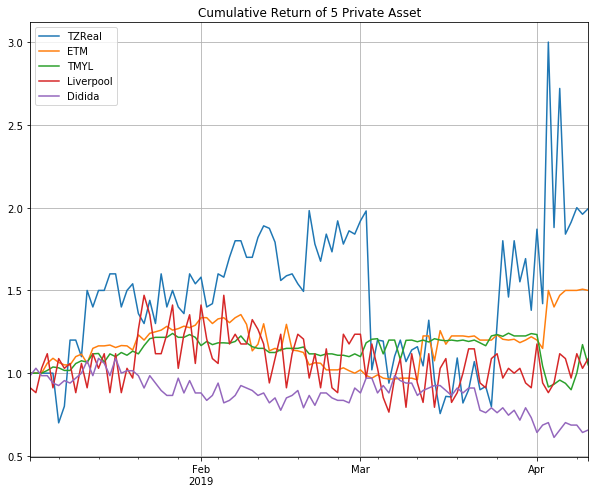

In [42]:
#了解各股票的收益率状况,并作图
returnss = returnss.dropna()
cumreturn = (1+ returnss).cumprod()
#sh_return.plot()
#plt.title('Daily Return of 5 Private Asset(2019)')
#plt.legend(bbox_to_anchor = (0.5,-0.3),ncol = 5,fancybox = True,shadow = True)
cumreturn.plot(figsize=(10, 8), grid=True)
plt.title('Cumulative Return of 5 Private Asset')

In [43]:
#构建一个MeanVariance类,该类可以根据输入的收益率序列,求解二次规划问题,计算出最优资产比例,并绘制最小方差前缘曲线
#定义 MeanVariance类
from matplotlib import pyplot as plt
from scipy import linalg
import numpy as np
import ffn
import cvxopt
from cvxopt import matrix
class MeanVariance:
    #定义构造器,传入收益率数据(dataframe格式的每日收益率)
    def __init__(self,returns):
        self.returns = returns

    #定义最小化方差的函数,即求解二次规划
    def minVar(self,goalRet):
        covs = np.array(self.returns.cov())
        means = np.array(self.returns.mean())
        L1 = np.append(np.append(covs.swapaxes(0,1),[means],axis=0),
                       [np.ones(len(means))],axis=0).swapaxes(0,1)

        L2 = list(np.ones(len(means)))
        L2.extend([0,0])
        L3 = list(means)
        L3.extend([0,0])
        L4 = np.array([L2,L3])
        L = np.append(L1,L4,axis=0)
        results = linalg.solve(L,np.append(np.zeros(len(means)),[1,goalRet]))

        return np.array([list(self.returns.columns), results[:-2]])

    #定义绘制最小方差前缘曲线函数
    def frontierCurve(self):
        goals = [x/500000 for x in range(-100,4000)]
        variances = list(map(lambda x: self.calVar(self.minVar(x)[1,:].astype(np.float)),goals))
        plt.plot(variances,goals)

    #给定各资产的比例,计算收益率的均值
    def meanRet(self,fracs):
        meanRisky = ffn.to_returns(self.returns).mean()
        #不符合条件时,弹出错误
        assert len(meanRisky) == len(fracs), 'length of fractions must be equal to number of assets'
        return np.sum(np.multiply(meanRisky,np.array(fracs)))

    #给定各资产的比例,计算收益率方差
    def calVar(self,fracs):
        #np.dot 可以将dataframe类型与矩阵直接相乘,得到的结果是array
        return (np.dot(np.dot(fracs,self.returns.cov()),fracs))

    #sim_weight = np.apply_along_axis(lambda x: x/sum(x),1,xim_weight)
    #apply_along_axis可以将函数作用于矩阵的行或者列
    #lambda函数的作用是对传入的参数直接给出结果,如果需要传入多个参数,可以写成array的形式传入,此案列中应用到了对数据的标准化中

    def solve_quadratic_problem(self,goal):
        covs = np.array(self.returns.cov())
        means = np.array(self.returns.mean())
        P = matrix(np.dot(2,covs))
        Q = matrix(np.zeros((len(means),1)))
        G = -matrix(np.zeros((len(means),len(means))))
        A = matrix(np.append([np.ones(len(means))],[means],axis=0))
        h = matrix(np.zeros((len(means),1)))
        b = matrix(np.array([[1,goal]]).swapaxes(0,1))
        sol = cvxopt.solvers.qp(P, Q, G , h, A, b)
        return sol

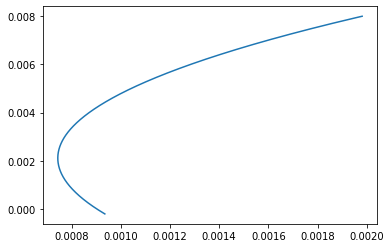

In [44]:
MeanVariance = MeanVariance(returnss)
MeanVariance.frontierCurve()

In [45]:
MeanVariance.minVar(0.3)

array([['TZReal', 'ETM', 'TMYL', 'Liverpool', 'Didida'],
       ['6.336426538565317', '6.506580378016671', '-0.42357348604790795',
        '4.171052364134665', '-15.590485794668744']], dtype='<U32')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x108210990>,
      dtype=object)

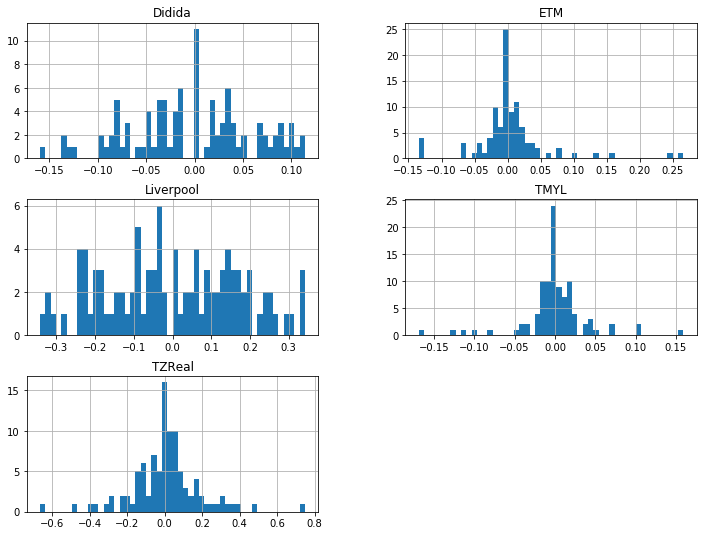

In [46]:
#计算对数收益率。金融计算收益率的时候大部分用对数收益率 (Log Return) 而不是用算数收益率
log_returns = np.log(clean_data / clean_data.shift(1))
log_returns.hist(bins=50, figsize=(12, 9))

In [47]:
#使用对数收益率为收益率
rets = log_returns
#计算年化收益率
year_ret = rets.mean() * 252
#计算协方差矩阵
year_volatility = rets.cov() * 252

In [48]:
#我们一共有10支股票
number_of_assets = 5
#生成10个随机数
weights = np.random.random(number_of_assets)
#将10个随机数归一化，每一份就是权重，权重之和为1
weights /= np.sum(weights)
weights

array([0.18804954, 0.284529  , 0.07475843, 0.13788524, 0.3147778 ])

In [49]:
portfolio_returns = []
portfolio_volatilities = []
for p in range (200):
    weights = np.random.random(number_of_assets)
    weights /= np.sum(weights)
    portfolio_returns.append(np.sum(rets.mean() * weights) * 252)
    portfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(rets.cov() * 252, weights))))

In [50]:
portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)

In [51]:
def statistics(weights):        
    #根据权重，计算资产组合收益率/波动率/夏普率。
    #输入参数
    #==========
    #weights : array-like 权重数组
    #权重为股票组合中不同股票的权重    
    #返回值
    #=======
    #pret : float
    #      投资组合收益率
    #pvol : float
    #      投资组合波动率
    #pret / pvol : float
    #    夏普率，为组合收益率除以波动率，此处不涉及无风险收益率资产
    #

    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [52]:
bnds = tuple((0, 1) for x in range(number_of_assets))
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

In [53]:
import scipy.optimize as sco
def min_func_sharpe(weights):
    return -statistics(weights)[2]
opts = sco.minimize(min_func_sharpe, number_of_assets * [1. / number_of_assets,], method='SLSQP',  bounds=bnds, constraints=cons)

In [54]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2
optv = sco.minimize(min_func_variance, number_of_assets * [1. / number_of_assets,], method='SLSQP', bounds=bnds, constraints=cons)

In [59]:
statistics(optv['x']).round(3)

array([0.085, 0.431, 0.196])

In [56]:
def min_func_port(weights):
    return statistics(weights)[1]  

In [57]:
target_returns = np.linspace(0.2, 1, 30)

In [58]:
target_volatilities = []
for tret in target_returns:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, number_of_assets * [1. / number_of_assets,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    target_volatilities.append(res['fun'])

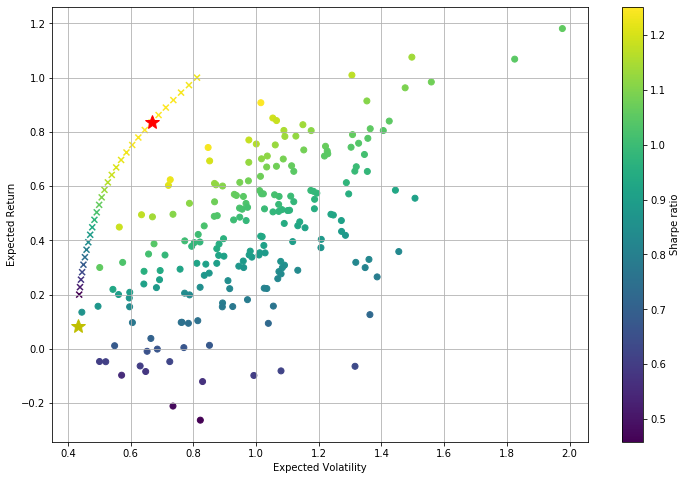

In [60]:
#画散点图
plt.figure(figsize=(12, 8))
#圆点为随机资产组合
plt.scatter(portfolio_volatilities, portfolio_returns,
            c=portfolio_returns / portfolio_volatilities, marker='o')
#叉叉为有效边界            
plt.scatter(target_volatilities, target_returns,
            c=target_returns / target_volatilities, marker='x')
#红星为夏普率最大值的资产组合            
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0)
#黄星为最小方差的资产组合            
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=15.0)
            # minimum variance portfolio
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe ratio')

In [61]:
import scipy.interpolate as sci
ind = np.argmin(target_volatilities)
upper_half_volatilities = target_volatilities[ind:]
upper_half_returns = target_returns[ind:]
tck = sci.splrep(upper_half_volatilities, upper_half_returns)
#tck参数用于构造有效边界函数f(x)
def f(x):
    #有效边界函数 (样条函数逼近).
    return sci.splev(x, tck, der=0)
#同时也构造有效边界函数f(x)的一阶导数函数df(x)
def df(x):
    #有效边界函数f(x)的一阶导数函数 
    return sci.splev(x, tck, der=1)
def equations(p, risk_free_return=0.02):
    eq1 = risk_free_return - p[0]
    eq2 = risk_free_return + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3
opt = sco.fsolve(equations, [0.01, 0.50, 0.15])
opt

array([0.02      , 1.22151293, 0.6826    ])

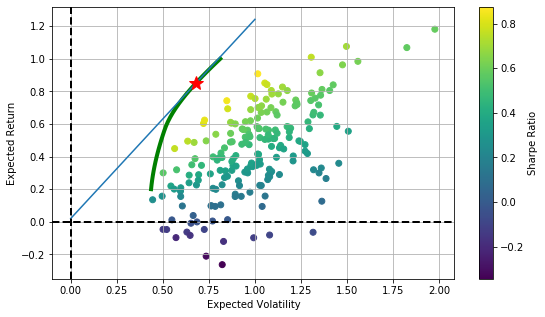

In [71]:
plt.figure(figsize=(9, 5))
#圆点为随机资产组合
plt.scatter(portfolio_volatilities, portfolio_returns,
            c=(portfolio_returns - 0.02) / portfolio_volatilities, marker='o')
#绿色线为有效边界
plt.plot(upper_half_volatilities, upper_half_returns, 'g', lw=4.0)

#设定资本市场线CML的x范围从0到0.6           
cml_x = np.linspace(0.0, 1)
#带入公式a+b*x求得y,作图
plt.plot(cml_x, opt[0] + opt[1] * cml_x, lw=1.5)
#标出资本市场线与有效边界的切点，红星处            
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')

In [66]:
from scipy import stats
opt_weights = opts['x'].round(3)  # opt_weights是最优风险组合权重
actual_opt_portfolio_returns = np.sum(rets * opt_weights, axis=1)  #axis=1 是按行求和  一行中的每一列相加
seven_day_year_returns = 252 * (actual_opt_portfolio_returns.shift(7) + actual_opt_portfolio_returns.shift(6) + actual_opt_portfolio_returns.shift(5) + actual_opt_portfolio_returns.shift(4) + actual_opt_portfolio_returns.shift(3) + actual_opt_portfolio_returns.shift(2) + actual_opt_portfolio_returns.shift(1)) / 7
seven_day_year_returns = seven_day_year_returns.dropna()   
confidence_range = stats.t.interval(0.90, len(seven_day_year_returns)-1, np.mean(seven_day_year_returns), stats.sem(seven_day_year_returns))
confidence_range

(0.3251537369695811, 1.2433057426978082)

In [81]:
## List of stock tickers 

stocks1 = ['TZReal', 'ETM', 'TMYL'] # High 
stocks2 = ['Liverpool', 'Didida'] # Low

# weights for stocks1
Minimal_gewicht1 = 0.0
Maximal_gewicht1 = 1.0
# weights for stocks2
Minimal_gewicht2 = 0.0
Maximal_gewicht2 = 1.0

#start = '2016-12-31'
#end = '2017-12-31'

Scale = 100 
rf = 0.01
target = 0.85 #the return we want
targetlen = target / len(returnss)
stocklist = stocks1 + stocks2

In [82]:
## Optimization!

def optimal_portfolio(returns):
    
    n = len(returns)
    N1 = len(stocks1)
    N2 = len(stocks2)
    returns = np.asmatrix(returns)
    pbar = cvxopt.matrix(np.mean(returns, axis=1))
    
    N=Scale
    mus_min=max(min(pbar),0)
    mus_max=max(pbar)
    mus_step=(mus_max - mus_min) / (N-1)
    mus = [mus_min + i*mus_step for i in range(N)]

    S = cvxopt.matrix(np.cov(returns))
    #pbar = opt.matrix(np.mean(returns, axis=1))
    
    #constraint matrices
    dank = -np.array(np.eye(n))
    dabbie = np.array(np.eye(n))
    #ye = np.vstack((dank, dabbie))
    
    dd = np.concatenate((-np.transpose(pbar), dank),0)
    mm = np.concatenate((np.transpose(pbar), dabbie),0)
    ye = np.vstack((dd, mm))
    G = cvxopt.matrix(ye, tc='d')
    
    #G = opt.matrix(np.concatenate((-np.transpose(pbar),ye),0))
    #G = opt.matrix(ye, tc='d')
    
    d1 = -np.ones((N1,1))*Minimal_gewicht1 
    e1 = np.ones((N1,1))*Maximal_gewicht1
    d2 = -np.ones((N2,1))*Minimal_gewicht2
    e2 =  np.ones((N2,1))*Maximal_gewicht2
    min_constraint = np.vstack((d1, d2))
    max_constraint = np.vstack((e1, e2))
    dodo = np.vstack((min_constraint, max_constraint))
    A = cvxopt.matrix(1.0, (1, n))
    b = cvxopt.matrix(1.0)
    
    """
    ## Calculate portfolios for efficient frontier (need this to find sharpe optimal portfolio)
    portfolios=[]
    for r_min in mus:
        eee = np.vstack((-np.ones((1,1))*r_min, min_constraint))
        fff = np.vstack((np.ones((1,1))*r_min, max_constraint))
        h = cvxopt.matrix(np.concatenate((eee, fff),0))
        
        #h = cvxopt.matrix(np.concatenate((-np.ones((1,1))*r_min, dodo),0))
        
        sol = solvers.qp(S, -pbar, G, h, A, b)['x']
        portfolios.append(sol)
    """
    
    

    ## Calculate target return portfolio
    eee = np.vstack((-np.ones((1,1))*targetlen, min_constraint))
    fff = np.vstack((np.ones((1,1))*targetlen, max_constraint))
    h = cvxopt.matrix(np.concatenate((eee, fff),0))
    portfolios = [solvers.qp(S, -pbar, G, h, A, b)['x']]
    
   
    ## Calculate Risk and Return
    returns = np.asarray([blas.dot(pbar, x) for x in portfolios])
    risks = np.asarray([np.sqrt(blas.dot(x, S*x)) for x in portfolios])
    
    # Approximates the position of the maximum Sharpe portfolio (also called tangent portfolio)
    # the bigger the 'scale' parameter the more accurate the calculation of the maximum sharpe portfolio!
    slope = (returns-(rf/252))/risks
    sharpe_opt = slope.argmax()

    return  returns, risks, portfolios, G, h, mus, sharpe_opt

exp_returns, exp_risk, weights, G, h, mus, sharpe = optimal_portfolio(returns.T)

     pcost       dcost       gap    pres   dres
 0: -7.5412e-03 -5.6299e+00  2e+01  2e+00  5e-16
 1: -7.4936e-03 -2.4211e+00  3e+00  2e-02  4e-16
 2: -7.5181e-03 -2.0018e-01  2e-01  1e-03  4e-16
 3: -6.9791e-03 -3.3103e-02  3e-02  2e-04  1e-16
 4: -7.1254e-03 -8.9306e-03  2e-03  1e-05  6e-17
 5: -7.3520e-03 -7.6618e-03  3e-04  1e-06  1e-15
 6: -7.4034e-03 -7.4132e-03  1e-05  2e-08  2e-14
 7: -7.4076e-03 -7.4077e-03  1e-07  2e-10  2e-14
 8: -7.4077e-03 -7.4077e-03  1e-09  2e-12  2e-14
Optimal solution found.


/Users/Tim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  
/Users/Tim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


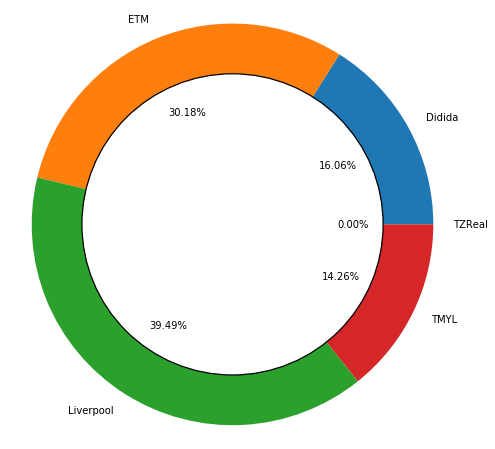

In [83]:
stocklist1 = sorted(stocklist)
labels = stocklist1
weights1 = np.array(weights[0]).tolist()
#explode = (0,0,0,0,0,0,0,0,0,0,0)

plt.pie(weights1, labels=labels, autopct='%.2f%%', shadow=False)
#Add a circle to give dougnut appearance 
circle = plt.Circle((0,0), 0.75, color='black', fc='white', linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(circle)
plt.axis('equal')
fig.set_size_inches(8,8)
plt.show()  

In [70]:
## This will print the expected annualized return, this should be the same or very close to the target 

print(exp_returns*len(returnss))

[0.85]
